Muhammad Hassaan Azam

AI/ML Intern

DHC 831

# Task 3: Satellite Image Analysis for Deforestation Monitoring

## Important Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image

## Loading Dataset

The "Planet: Understanding the Amazon from Space" dataset focuses on using satellite data to track human impacts on the Amazon rainforest. It is associated with a Kaggle competition that emphasizes analyzing satellite imagery to monitor environmental changes in the region.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nikitarom/planets-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/nikitarom/planets-dataset/versions/3


In [ ]:
import os

# test_img = tf.io.gfile.glob(str(path + '/planet/planet/test-jpg/*'))

train_img = tf.io.gfile.glob(str(path + '/planet/planet/train-jpg/*'))

train_class = tf.io.gfile.glob(str(path + '/planet/planet/train_classes.csv'))

# Print the paths of the first few images

# for imgname in test_img[:3]:
#     print(imgname)
for imgname in train_img[:3]:
    print(imgname)
print(train_class)
# train_class_df.head()
train_class_df=pd.read_csv(train_class[0])
train_class_df.head()

/root/.cache/kagglehub/datasets/nikitarom/planets-dataset/versions/3/planet/planet/train-jpg/train_21613.jpg
/root/.cache/kagglehub/datasets/nikitarom/planets-dataset/versions/3/planet/planet/train-jpg/train_12327.jpg
/root/.cache/kagglehub/datasets/nikitarom/planets-dataset/versions/3/planet/planet/train-jpg/train_30038.jpg
['/root/.cache/kagglehub/datasets/nikitarom/planets-dataset/versions/3/planet/planet/train_classes.csv']


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [ ]:
train_class_df.shape

(40479, 2)

A single image can have multiple labels in the dataset.

In [ ]:
# Get all tags as a single list
all_tags_list = train_class_df['tags'].str.split().sum() # Each tag is one label

# Use pandas' value_counts to get unique tags and their counts
tag_counts_series = pd.Series(all_tags_list).value_counts()

# Print the unique tags and their counts
print(tag_counts_series)

# Get unique tags as a list
unique_tags = tag_counts_series.index.tolist()
print(f"\nUnique tags: {unique_tags}")

# Get the total number of unique tags
total_unique_tags = len(unique_tags)
print(f"\nTotal number of unique tags: {total_unique_tags}")

primary              37513
clear                28431
agriculture          12315
road                  8071
water                 7411
partly_cloudy         7261
cultivation           4547
habitation            3660
haze                  2697
cloudy                2089
bare_ground            862
selective_logging      340
artisinal_mine         339
blooming               332
slash_burn             209
blow_down              101
conventional_mine      100
Name: count, dtype: int64

Unique tags: ['primary', 'clear', 'agriculture', 'road', 'water', 'partly_cloudy', 'cultivation', 'habitation', 'haze', 'cloudy', 'bare_ground', 'selective_logging', 'artisinal_mine', 'blooming', 'slash_burn', 'blow_down', 'conventional_mine']

Total number of unique tags: 17


The occurrence of a label alongside other labels.

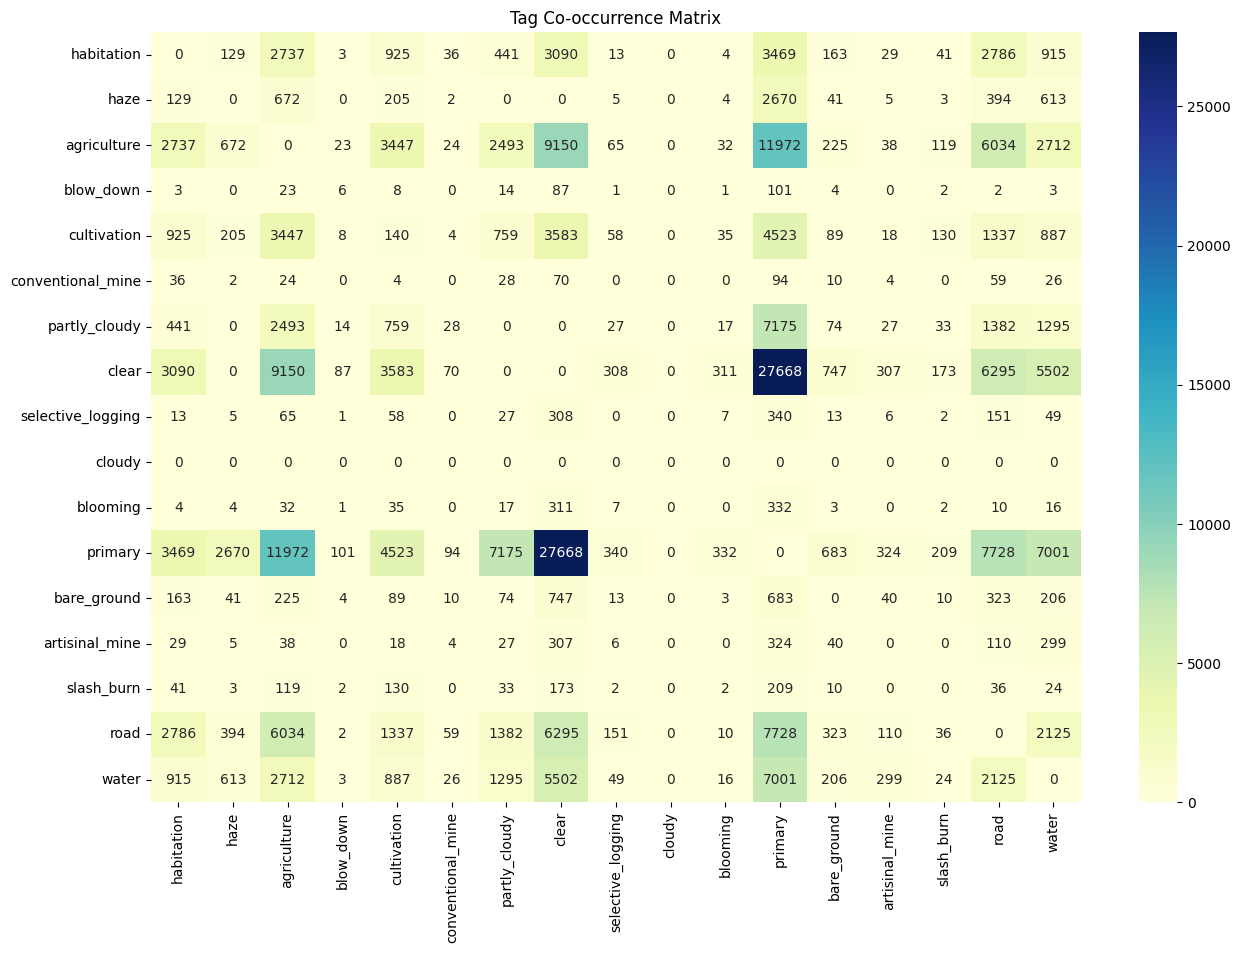

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique tags
unique_tags = list(set(train_class_df['tags'].str.split().sum()))

# Create co-occurrence matrix
co_occurrence_matrix = np.zeros((len(unique_tags), len(unique_tags)))

for index, row in train_class_df.iterrows():
    tags = row['tags'].split()
    for i in range(len(tags)):
        for j in range(i + 1, len(tags)):
            tag1_index = unique_tags.index(tags[i])
            tag2_index = unique_tags.index(tags[j])
            co_occurrence_matrix[tag1_index, tag2_index] += 1
            co_occurrence_matrix[tag2_index, tag1_index] += 1  # Make it symmetric

# Visualize using a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(co_occurrence_matrix, annot=True, fmt=".0f", cmap="YlGnBu",
            xticklabels=unique_tags, yticklabels=unique_tags)
plt.title("Tag Co-occurrence Matrix")
plt.show()

## Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

mlb = MultiLabelBinarizer()
# Load data
train_class_df = pd.read_csv(train_class[0])

# Create image paths
base_dir = os.path.join(path, 'planet/planet/train-jpg')
train_class_df['image_path'] = train_class_df['image_name'].apply(
    lambda x: os.path.join(base_dir, f"{x}.jpg")
)


# Create multi-label encoding BEFORE creating class_mapping
mlb = MultiLabelBinarizer()
mlb.fit(train_class_df['tags'].str.split()) # Fit the MultiLabelBinarizer to your data

# Now you can access mlb.classes_
class_mapping = {i: cls for i, cls in enumerate(mlb.classes_)}
print(class_mapping)
# Example output: {0: 'agriculture', 1: 'artisinal_mine', ...}


{0: 'agriculture', 1: 'artisinal_mine', 2: 'bare_ground', 3: 'blooming', 4: 'blow_down', 5: 'clear', 6: 'cloudy', 7: 'conventional_mine', 8: 'cultivation', 9: 'habitation', 10: 'haze', 11: 'partly_cloudy', 12: 'primary', 13: 'road', 14: 'selective_logging', 15: 'slash_burn', 16: 'water'}


I used the MultiLabelBinarizer for encoding.

In [ ]:
# Create multi-label encoding
mlb = MultiLabelBinarizer(classes=list(class_mapping.values()))
tags_matrix = mlb.fit_transform(train_class_df['tags'].str.split())

# Add label columns to DataFrame
label_cols = mlb.classes_
train_class_df[label_cols] = tags_matrix

# Split data
train_df, test_df = train_test_split(train_class_df, test_size=0.2, random_state=7)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=7)

# Create data generators
train_datagen = ImageDataGenerator(rescale=1/255.)

def create_generator(df):
    return train_datagen.flow_from_dataframe(
        dataframe=df,
        x_col='image_path',
        y_col=label_cols,
        class_mode='raw',
        target_size=(224, 224),
        batch_size=32,
        shuffle=True,
        validate_filenames=True
    )

train_generator = create_generator(train_df)
val_generator = create_generator(val_df)
test_generator = create_generator(test_df)

# Verify output
batch_x, batch_y = next(train_generator)
print(f"Image shape: {batch_x.shape}")  # (32, 224, 224, 3)
print(f"Label shape: {batch_y.shape}")  # (32, 17)
print("Sample labels:", batch_y[0])     # Multi-hot encoded array

Found 24287 validated image filenames.
Found 8096 validated image filenames.
Found 8096 validated image filenames.
Image shape: (32, 224, 224, 3)
Label shape: (32, 17)
Sample labels: [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]


In [ ]:
for t in train_generator:
    print(t)
    break

(array([[[[0.6509804 , 0.6745098 , 0.64705884],
         [0.6509804 , 0.6745098 , 0.64705884],
         [0.6509804 , 0.6745098 , 0.64705884],
         ...,
         [0.654902  , 0.68235296, 0.654902  ],
         [0.654902  , 0.68235296, 0.654902  ],
         [0.654902  , 0.68235296, 0.654902  ]],

        [[0.6509804 , 0.6745098 , 0.64705884],
         [0.6509804 , 0.6745098 , 0.64705884],
         [0.6509804 , 0.6745098 , 0.64705884],
         ...,
         [0.654902  , 0.68235296, 0.654902  ],
         [0.654902  , 0.68235296, 0.654902  ],
         [0.654902  , 0.68235296, 0.654902  ]],

        [[0.6509804 , 0.6745098 , 0.64705884],
         [0.6509804 , 0.6745098 , 0.64705884],
         [0.6509804 , 0.6745098 , 0.64705884],
         ...,
         [0.654902  , 0.68235296, 0.654902  ],
         [0.654902  , 0.68235296, 0.654902  ],
         [0.654902  , 0.68235296, 0.654902  ]],

        ...,

        [[0.6627451 , 0.6901961 , 0.6627451 ],
         [0.6627451 , 0.6901961 , 0.6627451 

## Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC
# Define the model architecture
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
pretrained_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
pretrained_model.trainable = False
x = pretrained_model(input_layer, training=False)
bl = BatchNormalization()(x)
flat = Flatten()(bl)
drop = Dropout(0.5)(flat)
dense = Dense(512, activation='relu')(drop)
drop = Dropout(0.5)(dense)
batch = BatchNormalization()(drop)
dense = Dense(32, activation='relu')(batch)
batch = BatchNormalization()(dense)
output_layer = Dense(len(class_mapping), activation='sigmoid')(batch)

model_resnet50 = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_resnet50.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=[Precision(), Recall(), AUC()])
model_resnet50.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 17)                  │             561 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,664,145 (94.09 MB)

 Trainable params: 1,071,249 (4.09 MB)

 Non-trainable params: 23,592,896 (90.00 MB)

Model Fitting

In [ ]:
# Train the model
history = model_resnet50.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


759/759 ━━━━━━━━━━━━━━━━━━━━ 116s 131ms/step - auc: 0.8099 - loss: 0.4711 - precision: 0.4596 - recall: 0.6695 - val_auc: 0.9535 - val_loss: 0.1927 - val_precision: 0.8143 - val_recall: 0.6953
Epoch 2/50
759/759 ━━━━━━━━━━━━━━━━━━━━ 122s 115ms/step - auc: 0.9512 - loss: 0.1936 - precision: 0.8410 - recall: 0.6652 - val_auc: 0.9585 - val_loss: 0.1796 - val_precision: 0.8514 - val_recall: 0.6973
Epoch 3/50
759/759 ━━━━━━━━━━━━━━━━━━━━ 141s 115ms/step - auc: 0.9540 - loss: 0.1873 - precision: 0.8449 - recall: 0.6752 - val_auc: 0.9599 - val_loss: 0.1763 - val_precision: 0.8521 - val_recall: 0.7040
Epoch 4/50
759/759 ━━━━━━━━━━━━━━━━━━━━ 163s 142ms/step - auc: 0.9563 - loss: 0.1826 - precision: 0.8479 - recall: 0.6832 - val_auc: 0.9612 - val_loss: 0.1734 - val_precision: 0.8618 - val_recall: 0.7114
Epoch 5/50
759/759 ━━━━━━━━━━━━━━━━━━━━ 88s 115ms/step - auc: 0.9558 - loss: 0.1847 - precision: 0.8474 - recall: 0.6862 - val_auc: 0.9607 - val_loss: 0.1746 - val_precision: 0.8626 - val_recall:

## Model Evaluation

In [ ]:
model_resnet50.evaluate(test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


253/253 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - auc: 0.9622 - loss: 0.1696 - precision: 0.8581 - recall: 0.7268


[0.16709177196025848,
 0.859421968460083,
 0.7263914942741394,
 0.9634708762168884]

In [ ]:
import numpy as np

# Assuming you have your test generator (test_generator)

# Get the true labels (y_true)
y_true = []
for i in range(len(test_generator)):
    _, batch_y = test_generator[i]  # Get the labels from the generator
    y_true.extend(batch_y)  # Extend the list with labels from the current batch
y_true = np.array(y_true)  # Convert to a NumPy array

# Get the predicted labels (y_pred)
y_pred_probs = model_resnet50.predict(test_generator)  # Get predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Now you have y_true and y_pred, which you can use with the calculate_metrics function.

253/253 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step


Results

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, jaccard_score

def calculate_metrics(y_true, y_pred):
    """
    Calculates various metrics for multi-label classification.

    Args:
        y_true: True labels (multi-hot encoded).
        y_pred: Predicted labels (multi-hot encoded).

    Returns:
        A dictionary containing the calculated metrics.
    """

    metrics = {}

    # Accuracy
    # metrics['Accuracy'] = accuracy_score(y_true, y_pred) # accuracy becomes less informative and can be misleading.

    metrics['Precision_Weighted'] = precision_score(y_true, y_pred, average='weighted', zero_division=1)

    metrics['Recall_Weighted'] = recall_score(y_true, y_pred, average='weighted')

    metrics['F1_Weighted'] = f1_score(y_true, y_pred, average='weighted')

    metrics['Jaccard_Weighted'] = jaccard_score(y_true, y_pred, average='weighted')

    return metrics



# Example usage:
# Assuming you have y_true and y_pred (multi-hot encoded)
metrics = calculate_metrics(y_true, y_pred)
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")
# print(metrics)

Precision_Weighted: 0.8454537180728346
Recall_Weighted: 0.7263915216267448
F1_Weighted: 0.7350512392760783
Jaccard_Weighted: 0.6504553085482647


## Conclusion

We utilized a pretrained ResNet50 model, which provides very good results for multi-label detection.